# NS仿真

In [1]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.animation as ani

dt=1#步长
Cn=0#换道次数
Ch=[]#换道信息记录
s=30#均布距离
l=6#标准车长，同时也是元胞长度，卡车长度为其两倍
v_max=5#标准车辆最大速度
vh_max=3#卡车最大速度
pm=1/10#慢化概率
ph=0.2#卡车概率

In [2]:
class Cell:#元胞定义
    def __init__(self,ID=0,LID=1,CL=6,T=10,S=float("inf"),V=0,X=0,flag=0,stop=0,p=0.1):
        self.ID=ID#元胞ID
        self.l=CL#元胞长度
        self.LID=[LID for t in range(T)]#元胞所在车道ID
        self.FID=-1#跟驰前车ID
        self.BID=-1#被跟驰后车ID
        self.FCID=-1#换道后 前车ID
        self.BCID=-1#换道后 后车ID
        self.FFlag=0#跟驰检测
        self.CFlag=-1#换道检测
        self.s=[S for t in range(T)]#车头间距数据储存
        self.cs=[S for t in range(T)]#换道车头间距数据储存
        self.cbs=[S for t in range(T)]#换道后车车头间距数据储存
        self.v=[V for t in range(T)]#速度数据储存
        self.x=[X for t in range(T)]#位移数据储存
        self.flag=flag#是否在路段内
        self.stop=stop#是否停止
        self.p=p#驾驶激进程度

In [3]:
class Lane:#车道定义
    def __init__(self,ID=0,LL=1000,Circle=0,T=3600,Iq=1000/3600,flag=1):
        self.flag=flag#末端能否通行
        self.ID=ID#车道ID
        self.L=LL#车道长度
        self.Iq=Iq#输入流量
        if Circle==1:#周期边界
            self.CID=0#车道下次到达的车辆的ID
            self.Cells=[Cell(n,ID,CL=RDMH()*l,T=T,V=0,X=n*s) for n in range(int(LL/s))]
        else:#开放边界
            pass

In [4]:
class Space:#元胞空间定义
    def __init__(self,SL=1000,ln=1,Circle=0,T=3600,Iq=1000/3600,DT=0):
        self.L=SL#元胞空间总长
        if Circle==1:#设置边界条件
            self.Lanes=[Lane(l,SL,Circle,T=T,Iq=Iq) for l in range(ln)]
        else:#开放边界
            pass
        if DT!=0:#设置路段检测器
            self.DT=[Detector(n*SL/DT) for n in range(DT)]

In [5]:
class Detector:#检测器定义
    def __init__(self,X=0):
        self.x=X#检测器位置
        self.v=0#平均速度
        self.q=0#平均流量

In [6]:
def RDM(v=0):#随机慢化概率
    u=random.uniform(0,1)
    if u<pm:
        return 1
    else:
        return 0

In [7]:
def RDMH():#卡车概率
    h=random.uniform(0,1)
    if h<ph:
        return 2
    else:
        return 1

In [8]:
def RDMC(p=0.1):#换道概率
    c=random.uniform(0,1)
    if c<p:
        return 1
    else:
        return 0

In [9]:
def NS(C1,t,LN,Circle=0,Detectors=None):#NS模型原本
    #加速
    if C1.l==l:
        C1.v[t+1]=min(C1.v[t]+1,v_max)
    else:
        C1.v[t+1]=min(C1.v[t]+1,vh_max)
    #减速
    C1.v[t+1]=min(C1.v[t+1],C1.s[t]-C1.l/l)
    #随机慢化
    if RDM(C1.v[t]):
        C1.v[t+1]=max(C1.v[t+1]-1,0)
    #位置更新
    C1.x[t+1]=C1.x[t]+C1.v[t+1]*l
    if Circle==1:
        if C1.x[t+1]>=LN.L:
            C1.x[t+1]=C1.x[t+1]-LN.L

In [10]:
def NSC(V0=0,V3=0,G1=s,G2=s,G3=s,p=0.1):
    if RDMC(p):
        if G1<G2 and V0>G1 and V3<G3:
            return 1
        else:
            return 0
    else:
        return 0

In [11]:
def Simulation(L=1000,ln=1,Circle=0,T=3600,Iq=1000/3600,DT=0):#仿真+可视化
    global Cn
    global Ch
    #初始化
    T=int(T/dt)
    SPC=Space(L,ln,Circle,T,DT)
    #路段内的车
    Cells=[]
    for LN in SPC.Lanes:
        Cells.extend(LN.Cells)
    #仿真
    for t in range(T-1):
        #跟驰判断与匹配
        for C in Cells:
            if C.stop==0:
                C.FFlag=0
                for F in Cells:
                    if F.LID[t]==C.LID[t] and F.x[t]>C.x[t]:
                        C.FFlag=1
                        if F.x[t]-C.x[t]<C.s[t]:
                            C.FID=Cells.index(F)
                            C.s[t]=F.x[t]-C.x[t]
                if C.FFlag==0:
                    for F in Cells:
                        if F.LID[t]==C.LID[t] and F.x[t]+L>C.x[t]:
                            C.FFlag=1
                            if F.x[t]+L-C.x[t]<C.s[t]:
                                C.FID=Cells.index(F)
                                C.s[t]=F.x[t]+L-C.x[t]
                if C.FFlag==0:
                    C.FID=-1
        
        #跟驰
        for C in Cells:
            if C.stop==0:
                if C.FFlag==1:
                    NS(C,t,SPC.Lanes[C.LID[t]],Circle)
                    if C.x[t+1]<0:
                        print(C.v[t],C.x[t])
                else:
                    print(" FID error")
        
        #后车查询
        for C in Cells:
            for B in Cells:
                if B.FID==Cells.index(C):
                    C.BID=Cells.index(B)
                    break
            C.BID=-1
        
        #相邻车道前车判断与匹配
        for C in Cells:
            if C.stop==0:
                C.FCID=-1
                for F in Cells:
                    if ((F.LID[t]==1 and C.LID[t]==0) or (F.LID[t]==0 and C.LID[t]==1)) and 0<F.x[t]-C.x[t]<C.cs[t]:
                        C.FCID=Cells.index(F)
                        C.cs[t]=F.x[t]-C.x[t]
                if C.FCID==-1:
                    for F in Cells:
                        if ((F.LID[t]==1 and C.LID[t]==0) or (F.LID[t]==0 and C.LID[t]==1)) and 0<F.x[t]+L-C.x[t]<C.cs[t]:
                            C.FCID=Cells.index(F)
                            C.cs[t]=F.x[t]+L-C.x[t]
                if C.FCID==-1:
                    print("FCID ERROR")
        
        #相邻车道后车判断与匹配
        for C in Cells:
            if C.stop==0:
                C.BCID=-1
                for B in Cells:
                    if ((B.LID[t]==1 and C.LID[t]==0) or (B.LID[t]==0 and C.LID[t]==1)) and 0<C.x[t]-B.x[t]<C.cbs[t]:
                        C.BCID=Cells.index(B)
                        C.cbs[t]=C.x[t]-B.x[t]
                if C.BCID==-1:
                    for B in Cells:
                        if ((B.LID[t]==1 and C.LID[t]==0) or (B.LID[t]==0 and C.LID[t]==1)) and 0<C.x[t]+L-B.x[t]<C.cbs[t]:
                            C.BCID=Cells.index(B)
                            C.cbs[t]=C.x[t]+L-B.x[t]
        
        #换道判断
        for C in Cells:
            if NSC(C.v[t],Cells[C.BCID].v[t],C.s[t]-Cells[C.FID].l,C.cs[t]-Cells[C.FCID].l,C.cbs[t]-Cells[C.BCID].l,C.p):
                if C.LID[t]==0:
                    C.CFlag=1
                else:
                    C.CFlag=0
            else:
                C.CFlag=-1
        
        #换道
        for C in Cells:
            if C.stop==0:
                while C.FID!=-1 and C.CFlag!=-1:#检测前50m内有无换道，有则推迟换道（推迟到下一个步长，保证换道判断同步性的同时，减少一队车辆同时换道的情况）
                    if Cells[C.FID].x[t]-C.x[t]>0:
                        if Cells[C.FID].x[t]-C.x[t]>50:
                            break
                    else:
                        if Cells[C.FID].x[t]+L-C.x[t]>50:
                            break
                    if Cells[C.FID].CFlag!=-1:
                        C.CFlag=-1
                        break
                    C.FID=Cells[C.FID].FID
                if C.CFlag!=-1:
                    if t>0/dt:#无预热
                        Cn+=1
                        Ch.append((C.x[t],C.LID[t]))
                    for tt in range(t,T-1):#换道成功后，修改该车所在车道
                        C.LID[tt]=C.CFlag
        
    print("ok")
    return Cells

In [12]:
def Visual(Results,ll,ln,T):#可视化
    x=[100*int(i/ln) for i in range(int(ln*ll/100+ln))]
    y=[i%ln for i in range(int(ln*ll/100+ln))]
    #print(y)
    s=[0 for i in range(int(ln*ll/100+ln))]
    for ch in Ch:
        if 0<=ch[0]<=ll:
            s[ln*int(ch[0]/100)+ch[1]]+=1
    plt.rcParams["font.family"] = 'Arial Unicode MS'
    plt.figure(figsize=(15,1))
    plt.xlim([0,ll])
    plt.scatter(x,y,s)
    fig=plt.figure(figsize=(15,1))
    plt.title("车道-位移")
    #plt.xlim([0,ll])
    #plt.ylim([0,1])
    ims=[]
    for t in range(int(T/dt)-1):
        if 0<t<720 and t%1==0:
            X=[C.x[t] for C in Results]
            Y=[C.LID[t] for C in Results]
            im=plt.scatter(X,Y,c='k').findobj()
            ims.append(im)
    animation = ani.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
    animation.save("test+.gif",writer='pillow')

In [13]:
L=6*1000
ln=2
Circle=1
T=1*60*60
Iq=1000/3600
DT=0
Results=Simulation(L,ln,Circle,T,Iq)

ok


In [14]:
print(Cn/dt,Cn/T)

11920.0 3.311111111111111


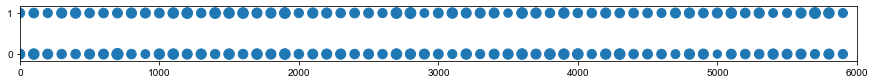

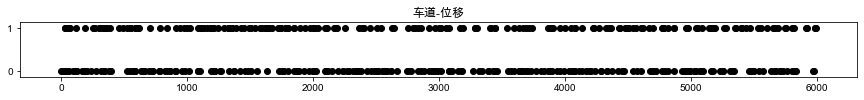

In [15]:
Visual(Results,L,ln,T)

> Sofarja@outlook.com
>
> ---
>
> 21018116
>
> 郭艺铧
>
> 交通工程